## Customer Segmentation  practice

### 0: Install Libraries and Packages

In [1]:

# Core
import numpy as np
import pandas as pd 
import plotly.express as px

# Graphing 
import seaborn as sns
import matplotlib.pyplot as plt

# Clustering & PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans 


# Machine Learning
#import pycaret.classification as clf

## 1: Load Data 
Using a dataset simulating customer data from a grocery store rewards program.
Kaggle https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign
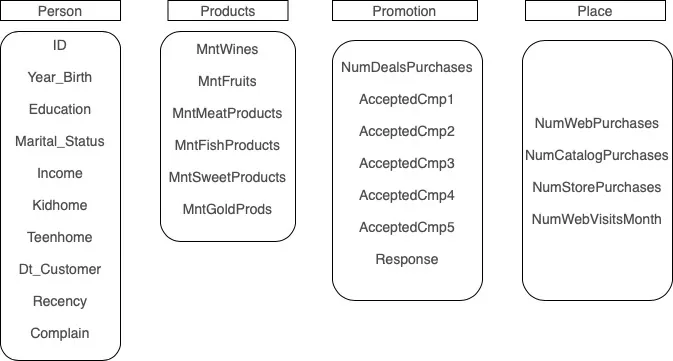

In [2]:
# Load raw data
data = pd.read_csv("data/marketing_campaign.csv", sep="\t")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2: Data Pre-Processing
2.1 Look for and handle any 
- duplicates
- missing values

2.2 
- remove un-needed columns
- replace any column names for consistency
- Change categorical columns to label encoding or one-hot-encoding

In [3]:
# 2.1 Data Cleaning
print(f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns.")
print(f"Data has {data.duplicated().sum()} duplicates and {data.isnull().sum().sum()} missing values.")

Dataset has 2240 rows and 29 columns.
Data has 0 duplicates and 24 missing values.


In [4]:
print(f"Column(s) with missing data values: {data.columns[data.isnull().any()][0]}")

Column(s) with missing data values: Income


Since only one column (Income) has null values and there are only 1% of rows with the null entries, I will drop the rows from our dataset.

In [5]:
# Dropping duplicates (just in case) and null values 
data.drop_duplicates(inplace=True) 
data.dropna(inplace=True)  

2.2 dealing with non-numeric columns

- 2.2a Identify the non-numeric columns
- 2.2b Determine the amount of categories in each categorical column
- 2.2c Clean up the data in the categorical column

In [6]:
# 2.2a Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")

Columns with data type int64: ID, Year_Birth, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response
Columns with data type float64: Income
Columns with data type object: Education, Marital_Status, Dt_Customer


In [7]:
# 2.2b Determine the number of categories for each categorical column
object_columns = data.select_dtypes(include=["object"]).columns
for col in object_columns:
    print(f"Unique values in column {col}: {data[col].nunique()}")

Unique values in column Education: 5
Unique values in column Marital_Status: 8
Unique values in column Dt_Customer: 662


In [8]:
data['Education'].value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [9]:
# Map Education entries to numerical values
data['Education']=data['Education'].map({'Basic':0, '2n Cycle':1, 'Graduation':2, 'Master':3, 'PhD':4}).astype(int)
data['Education'].value_counts()

Education
2    1116
4     481
3     365
1     200
0      54
Name: count, dtype: int64

In [10]:
data['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [11]:
# Change entries that are synonymous with single (Alone, Absurd, YOLO) to Single 
data['Marital_Status'] = data['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
# Change entries that are synonymous with "coupled" (Married, Together) to Coupled 
data['Marital_Status'] = data['Marital_Status'].replace(['Together', 'Married'], 'Coupled')
data['Marital_Status'].value_counts()

Marital_Status
Coupled     1430
Single       478
Divorced     232
Widow         76
Name: count, dtype: int64

In [12]:
# Map Marital Status to numerical values
data['Marital_Status'] = data['Marital_Status'].map({'Single': 1, 'Coupled': 2, 'Divorced':3, 'Widow':4}).astype(int)
data['Marital_Status'].value_counts()

Marital_Status
2    1430
1     478
3     232
4      76
Name: count, dtype: int64

In [13]:
data['Dt_Customer'].value_counts()

Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: count, Length: 662, dtype: int64

#### 2.2 INSIGHTS
- Since the Education and Marital_Status columns around five different categories, I encoded them numerically via mapping and converted the columns to integer for the machine learning model.
- Dt_Customer has a large amount of distince values (662) this indicates its not a categorial column. When inspecting the values it looks like a date in Day-Month-Year format. I will convert the column to a datetime object

In [14]:
# convert to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   int32         
 3   Marital_Status       2216 non-null   int32         
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i

### 3.0 Exploratory Data Analysis 

- 3.1 Review Statistics and Distributions of Numerical Columns
- 3.2 Identify if there are any outliers that need to be dealt with
- 3.3 Determine if there is any strong correlation between entries 

In [15]:
# 3.1 Numerical Statistics of columns
data.describe().T

,count,mean,min,25%,50%,75%,max,std
ID,2216.0,5588.353339,0.0,2814.75,5458.5,8421.75,11191.0,3249.376275
Year_Birth,2216.0,1968.820397,1893.0,1959.0,1970.0,1977.0,1996.0,11.985554
Education,2216.0,2.459838,0.0,2.0,2.0,3.0,4.0,1.004825
Marital_Status,2216.0,1.957581,1.0,2.0,2.0,2.0,4.0,0.675269
Income,2216.0,52247.251354,1730.0,35303.0,51381.5,68522.0,666666.0,25173.076661
Kidhome,2216.0,0.441787,0.0,0.0,0.0,1.0,2.0,0.536896
Teenhome,2216.0,0.505415,0.0,0.0,0.0,1.0,2.0,0.544181
Dt_Customer,2216,2013-07-10 11:29:27.509025280,2012-07-30 00:00:00,2013-01-16 00:00:00,2013-07-08 12:00:00,2013-12-31 00:00:00,2014-06-29 00:00:00,NaN
Recency,2216.0,49.012635,0.0,24.0,49.0,74.0,99.0,28.948352
MntWines,2216.0,305.091606,0.0,24.0,174.5,505.0,1493.0,337.32792


#### 3.1 Insights
 - *Z_CostContact* and *Z_Revenue* are uniform and can be dropped.
 - There is a birth year from the 1800s which doesn't seem correct and may need to be dropped
 - From reviewing the standard deviation of the numeric columns, it looks like the *Income*, *MntWines* and *MntMeetProducts* have a significantly large standard deviation, thus there are probably outliers that need to be handled.
  

In [23]:
data[data['Year_Birth']<1940]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
192,7829,1900,1,3,36640.0,1,0,2013-09-26,99,15,...,5,0,0,0,0,0,1,3,11,0
239,11004,1893,1,1,60182.0,0,1,2014-05-17,23,8,...,4,0,0,0,0,0,0,3,11,0
339,1150,1899,4,2,83532.0,0,0,2013-09-26,36,755,...,1,0,0,1,0,0,0,3,11,0


In [24]:
# Drop the uniform columns Z_CostContact and Z_Revenue
data.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
# Only have rows where the birth year is 1940 and older
data = data[data['Year_Birth']>=1940]

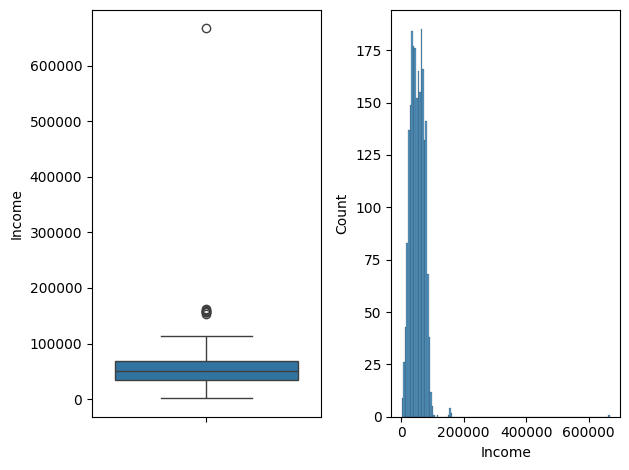

In [28]:
# View the Income data as a row of 2 subplots
fig, axs = plt.subplots(1,2)
# Create boxplot
sns.boxplot(data['Income'], ax=axs[0])
# Create histogram
sns.histplot(data['Income'], ax=axs[1])
plt.tight_layout()
plt.show()

It looks like their is an extreme outlier with an income of over 600,000 and is skewing the distribution. Lets drop that value.

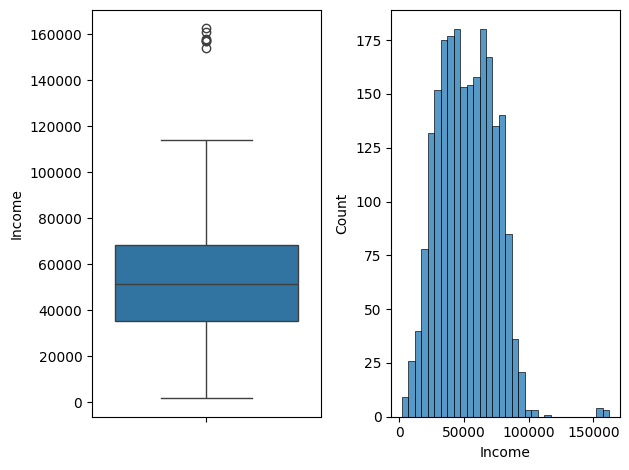

In [29]:
data = data[data['Income'] <= 200000]
# View the Income data as a row of 2 subplots
fig, axs = plt.subplots(1,2)
# Create boxplot
sns.boxplot(data['Income'], ax=axs[0])
# Create histogram
sns.histplot(data['Income'], ax=axs[1])
plt.tight_layout()
plt.show()